### Connect to Google Drive

In [1]:
# # Import libraries for importing files from Google drive to Colab
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authorize Google SDK to access Google Drive from Colab

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [2]:
# download = drive.CreateFile({'id': '請自行輸入自己上傳google drive檔案的連結id'})
# download.GetContentFile('spam.csv')

### Import Necessary Libraries

In [1]:
import os
import re
import tqdm
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import urllib.request
from typing import List
from collections import Counter
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Pre-processing

In [2]:
# read data from spam.csv

sms_data = pd.read_csv('./spam.csv', usecols=[0,1], encoding="latin")
sms_data.columns = ["label", "content"]
sms_data.head()

,label,content
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


開始進行模型建模之前，我們先對資料進行前處理。在前處理部分，我們會將文字轉化為小寫，移除標點符號，最後除了處理過的文本外，也輸出word-index、index-word、詞頻(word-frequency)、與總文本字數

In [3]:
class PreProcessor():
    '''Function to do preprocess of input corpus
    Parameters
    -----------
    corpus: str
        input corpus to be processed
    only_word: bool
        whether to filter out non-word
    min_freq: int
        minimum frequency of a word to be kept
    do_subsampling: bool
        whether to do subsampling
    '''
    
    def __init__(self, only_word: bool=False, min_freq: int=5, do_subsampling: bool=True, t: float=1e-5):
        self.only_word = only_word
        self.min_freq = min_freq
        self.do_subsampling = do_subsampling
        self.t = t
    
    def process(self, corpus: List[str]):
        
        word_dic = set()
        counter = Counter()
        processed_sentence = []
        
        for sentence in corpus:
            #將所有字詞轉為小寫
            sentence = sentence.lower()
            #移除標點符號(可以依據使用狀況決定是否要移除標點符號)
            
            if self.only_word:
                sentence = [word for word in re.findall(r"[a-zA-Z]*", sentence) if word != ""]
            else:
                punctuation_list = ['.', ',', '!', '?']
                for pun in punctuation_list:
                    sentence = sentence.replace(pun, ' '+pun)
                sentence = sentence.split(' ')
        
            #計算字詞頻率
            counter.update(sentence)
            processed_sentence.append(sentence)
    
        #移除頻率過小的字詞
        word_cnt = dict(filter(lambda x: x[1] > self.min_freq, counter.items()))
        #添加字詞到字典中
        
        self.word2idx = {word: idx for idx, word in enumerate(word_cnt.keys(), 0)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.word_frequency = word_cnt.copy()
        
        #將文本轉為ID型式與移除文本中頻率過小的文字
        self.processed_corpus = [[self.word2idx[word] for word in line if word in self.word2idx] for line in processed_sentence]
        self.total_num_words = sum([len(line) for line in self.processed_corpus])
        print(f"Before subsampling: {self.total_num_words} words")
        
        # 進行二次採樣(subsampling)
        if self.do_subsampling:
            self.processed_corpus = [[idx for idx in line if self.subsampling(idx)] for line in self.processed_corpus]
            self.total_num_words = sum([len(line) for line in self.processed_corpus])
            counter = Counter([self.idx2word[idx] for line in self.processed_corpus for idx in line])
            word_cnt = dict(counter.items())
            self.word_frequency = word_cnt.copy()
            print(f"After subsampling: {self.total_num_words} words")
        
        self.processed_corpus = [[idx for idx in line] for line in self.processed_corpus if len(line) != 0]
        
        return self.processed_corpus, self.word2idx, self.idx2word, self.word_frequency, self.total_num_words
    
    def subsampling(self, idx):
        
        p = self.t / self.word_frequency[self.idx2word[idx]] * self.total_num_words
        p_w = math.sqrt(p) + p
        
        return random.uniform(0, 1) < p_w

In [4]:
# 在前處理會透過subsampling來降低高頻詞的次數
pre_processor = PreProcessor(True, 5, True, 1e-4)
corpus, word2idx, idx2word, word2freq, total_num_words = pre_processor.process(sms_data['content'].values)

Before subsampling: 76478 words
After subsampling: 28903 words


### 自定義Dataset與Collate function

In [5]:
class GetAllDataset(Dataset):
    
    def __init__(self, corpus, word2freq, word2idx, idx2word, window_size, num_negatives):
        self.corpus = corpus
        self.word2freq = word2freq
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.window_size = window_size
        self.num_negatives = num_negatives
        
        self.all_targets, self.all_contexts = self._get_all_contexts_targets()
        self.all_negatives = self._get_all_negatives()
        
    def __len__(self):
        return len(self.all_targets)
    
    def __getitem__(self, idx):
        
        # 返回目標字詞、上下文與負採樣的目標
        return (self.all_targets[idx], self.all_contexts[idx], self.all_negatives[idx])
        
    
    def _get_all_contexts_targets(self):
        all_targets = []
        all_contexts = []
        
        for line in self.corpus:
            if len(line) < 2*self.window_size + 1:
                continue
            
            all_targets += [[word] for word in line[self.window_size:-self.window_size]]
            for index in range(self.window_size, len(line) - self.window_size):
                indices = list(range(max(0, index - self.window_size), min(len(line), index + self.window_size + 1)))
                indices.remove(index)
                all_contexts.append([line[idx] for idx in indices])
                               
        return all_targets, all_contexts
                               
    
    def _get_all_negatives(self):
        
        cur_exists_words = list(self.word2freq.keys())
        sampling_weights = [self.word2freq[word]**0.75 for word in self.word2freq]
        population = list(range(len(sampling_weights)))
        
        all_negatives = []
        neg_candidate = []
        i = 0
        for word in self.all_targets:
            negatives = []
            while len(negatives) < self.num_negatives:
                if i == len(neg_candidate):
                    neg_candidate = random.choices(population, sampling_weights, k=int(1e5))
                    neg_candidate = list(map(lambda x: self.word2idx[cur_exists_words[x]], neg_candidate))
                    i = 0
                if neg_candidate[i] != word[0]:
                    negatives.append(neg_candidate[i])
                i += 1
            all_negatives.append(negatives)        
        
        return all_negatives
    

def all_collate(data):
    contexts = []
    target_negative = []
    labels = []
    for target, context, negative in data:
        target_negative += [target + negative]
        labels += [[1] * len(target) + [0] * len(negative)]
        contexts += [context]
    
    return torch.tensor(contexts), torch.tensor(target_negative), torch.tensor(labels)

In [6]:
#查看資料產出
d_set = GetAllDataset(corpus, word2freq, word2idx, idx2word, window_size=1, num_negatives=3)
dataloader = DataLoader(d_set, batch_size=2, shuffle=True, collate_fn=all_collate)

#透過next與iter取出資料
next(iter(dataloader))

(tensor([[123,  99],
         [304, 982]]),
 tensor([[ 688,  783, 1556,  509],
         [ 169,  143,  854,  753]]),
 tensor([[1, 0, 0, 0],
         [1, 0, 0, 0]]))

### 自定義模型

In [9]:
class CBOW(nn.Module):
    
    def __init__(self, vocab_size, embed_size):
        super(CBOW, self).__init__()
        
        self.in_embedding = nn.Embedding(vocab_size, embed_size)
        self.out_embedding = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, contexts, targets):
        v = torch.mean(self.in_embedding(contexts), dim=1) # [batch * (# per docs), embed_size]
        u = self.out_embedding(targets)
        
        # do dot product to get output
        pred = torch.matmul(v[:,None,:], u.permute(0,2,1))
        
        return pred.squeeze(dim=1)

### 設置超參數

In [10]:
use_cuda = torch.cuda.is_available()
verbose = True
num_epochs = 100
batch_size = 512
embed_size = 100
lr = 0.01
model = CBOW(len(word2idx), embed_size)
if use_cuda:
    model.cuda()
    
criterion = nn.BCEWithLogitsLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
dataset = GetAllDataset(corpus, word2freq, word2idx, idx2word, 2, 5)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=all_collate)

### 開始訓練

In [11]:
# training
lst_loss = []
model.train()
for epc in tqdm.tqdm(range(num_epochs)):
    batch_loss = 0
    for i, (contexts, target_negative, labels) in enumerate(loader, 1):
        optimizer.zero_grad()
        
        if use_cuda:
            contexts = contexts.cuda()
            target_negative = target_negative.cuda()
            labels = labels.cuda()
        
        pred = model(contexts, target_negative)
        loss = criterion(pred.float(), labels.float())
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i % 500 == 0:
            print(f"Epoch: {epc + 1}/{num_epochs}, Batch: {i+1}/{len(dataset)/batch_size} Loss: {batch_loss / i:.5f}")
    
    if verbose:
        print(f"Epoch: {epc + 1}/{num_epochs}, Loss: {batch_loss / i:.5f}")
    
    lst_loss.append(batch_loss/i)

  2%|▏         | 2/100 [00:00<00:26,  3.74it/s]

Epoch: 1/100, Loss: 2.07784
Epoch: 2/100, Loss: 1.51606


  4%|▍         | 4/100 [00:00<00:20,  4.65it/s]

Epoch: 3/100, Loss: 1.14037
Epoch: 4/100, Loss: 0.84792
Epoch: 5/100, Loss: 0.62535


  7%|▋         | 7/100 [00:00<00:14,  6.47it/s]

Epoch: 6/100, Loss: 0.45413
Epoch: 7/100, Loss: 0.32896
Epoch: 8/100, Loss: 0.24147


 11%|█         | 11/100 [00:01<00:10,  8.24it/s]

Epoch: 9/100, Loss: 0.17997
Epoch: 10/100, Loss: 0.13707
Epoch: 11/100, Loss: 0.10691


 13%|█▎        | 13/100 [00:01<00:09,  8.94it/s]

Epoch: 12/100, Loss: 0.08655
Epoch: 13/100, Loss: 0.07072
Epoch: 14/100, Loss: 0.05927


 17%|█▋        | 17/100 [00:01<00:08,  9.97it/s]

Epoch: 15/100, Loss: 0.05092
Epoch: 16/100, Loss: 0.04391
Epoch: 17/100, Loss: 0.03855


 19%|█▉        | 19/100 [00:02<00:07, 10.35it/s]

Epoch: 18/100, Loss: 0.03410
Epoch: 19/100, Loss: 0.03058
Epoch: 20/100, Loss: 0.02754


 21%|██        | 21/100 [00:02<00:07, 10.57it/s]

Epoch: 21/100, Loss: 0.02496
Epoch: 22/100, Loss: 0.02283


 25%|██▌       | 25/100 [00:02<00:07, 10.14it/s]

Epoch: 23/100, Loss: 0.02087
Epoch: 24/100, Loss: 0.01919
Epoch: 25/100, Loss: 0.01764


 27%|██▋       | 27/100 [00:02<00:07, 10.25it/s]

Epoch: 26/100, Loss: 0.01638
Epoch: 27/100, Loss: 0.01525
Epoch: 28/100, Loss: 0.01422


 31%|███       | 31/100 [00:03<00:06, 10.42it/s]

Epoch: 29/100, Loss: 0.01332
Epoch: 30/100, Loss: 0.01248
Epoch: 31/100, Loss: 0.01166


 33%|███▎      | 33/100 [00:03<00:06, 10.56it/s]

Epoch: 32/100, Loss: 0.01102
Epoch: 33/100, Loss: 0.01040
Epoch: 34/100, Loss: 0.00982


 37%|███▋      | 37/100 [00:03<00:05, 10.87it/s]

Epoch: 35/100, Loss: 0.00927
Epoch: 36/100, Loss: 0.00878
Epoch: 37/100, Loss: 0.00836


 39%|███▉      | 39/100 [00:03<00:05, 10.94it/s]

Epoch: 38/100, Loss: 0.00793
Epoch: 39/100, Loss: 0.00754
Epoch: 40/100, Loss: 0.00720


 41%|████      | 41/100 [00:04<00:05, 11.01it/s]

Epoch: 41/100, Loss: 0.00686
Epoch: 42/100, Loss: 0.00656


 45%|████▌     | 45/100 [00:04<00:05, 10.27it/s]

Epoch: 43/100, Loss: 0.00626
Epoch: 44/100, Loss: 0.00598
Epoch: 45/100, Loss: 0.00572


 47%|████▋     | 47/100 [00:04<00:05, 10.27it/s]

Epoch: 46/100, Loss: 0.00549
Epoch: 47/100, Loss: 0.00526
Epoch: 48/100, Loss: 0.00505


 51%|█████     | 51/100 [00:05<00:04, 10.64it/s]

Epoch: 49/100, Loss: 0.00487
Epoch: 50/100, Loss: 0.00467
Epoch: 51/100, Loss: 0.00452


 53%|█████▎    | 53/100 [00:05<00:04, 10.75it/s]

Epoch: 52/100, Loss: 0.00435
Epoch: 53/100, Loss: 0.00417
Epoch: 54/100, Loss: 0.00402


 57%|█████▋    | 57/100 [00:05<00:03, 10.85it/s]

Epoch: 55/100, Loss: 0.00388
Epoch: 56/100, Loss: 0.00374
Epoch: 57/100, Loss: 0.00361


 59%|█████▉    | 59/100 [00:05<00:03, 10.84it/s]

Epoch: 58/100, Loss: 0.00349
Epoch: 59/100, Loss: 0.00337
Epoch: 60/100, Loss: 0.00327


 61%|██████    | 61/100 [00:05<00:03, 10.78it/s]

Epoch: 61/100, Loss: 0.00315
Epoch: 62/100, Loss: 0.00306


 65%|██████▌   | 65/100 [00:06<00:03, 10.11it/s]

Epoch: 63/100, Loss: 0.00295
Epoch: 64/100, Loss: 0.00286
Epoch: 65/100, Loss: 0.00278


 67%|██████▋   | 67/100 [00:06<00:03, 10.22it/s]

Epoch: 66/100, Loss: 0.00269
Epoch: 67/100, Loss: 0.00261
Epoch: 68/100, Loss: 0.00253


 71%|███████   | 71/100 [00:06<00:02, 10.36it/s]

Epoch: 69/100, Loss: 0.00246
Epoch: 70/100, Loss: 0.00240
Epoch: 71/100, Loss: 0.00232


 73%|███████▎  | 73/100 [00:07<00:02, 10.49it/s]

Epoch: 72/100, Loss: 0.00225
Epoch: 73/100, Loss: 0.00220
Epoch: 74/100, Loss: 0.00221


 77%|███████▋  | 77/100 [00:07<00:02, 10.70it/s]

Epoch: 75/100, Loss: 0.00213
Epoch: 76/100, Loss: 0.00206
Epoch: 77/100, Loss: 0.00197


 79%|███████▉  | 79/100 [00:07<00:01, 10.65it/s]

Epoch: 78/100, Loss: 0.00191
Epoch: 79/100, Loss: 0.00186
Epoch: 80/100, Loss: 0.00182


 81%|████████  | 81/100 [00:07<00:01, 10.73it/s]

Epoch: 81/100, Loss: 0.00176
Epoch: 82/100, Loss: 0.00173


 85%|████████▌ | 85/100 [00:08<00:01, 10.25it/s]

Epoch: 83/100, Loss: 0.00169
Epoch: 84/100, Loss: 0.00165
Epoch: 85/100, Loss: 0.00161


 87%|████████▋ | 87/100 [00:08<00:01, 10.53it/s]

Epoch: 86/100, Loss: 0.00157
Epoch: 87/100, Loss: 0.00152
Epoch: 88/100, Loss: 0.00148


 91%|█████████ | 91/100 [00:08<00:00, 10.73it/s]

Epoch: 89/100, Loss: 0.00146
Epoch: 90/100, Loss: 0.00143
Epoch: 91/100, Loss: 0.00139


 93%|█████████▎| 93/100 [00:09<00:00, 10.82it/s]

Epoch: 92/100, Loss: 0.00135
Epoch: 93/100, Loss: 0.00132
Epoch: 94/100, Loss: 0.00130


 97%|█████████▋| 97/100 [00:09<00:00, 10.71it/s]

Epoch: 95/100, Loss: 0.00126
Epoch: 96/100, Loss: 0.00124
Epoch: 97/100, Loss: 0.00120


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

Epoch: 98/100, Loss: 0.00117
Epoch: 99/100, Loss: 0.00123
Epoch: 100/100, Loss: 0.00112


### 視覺化loss

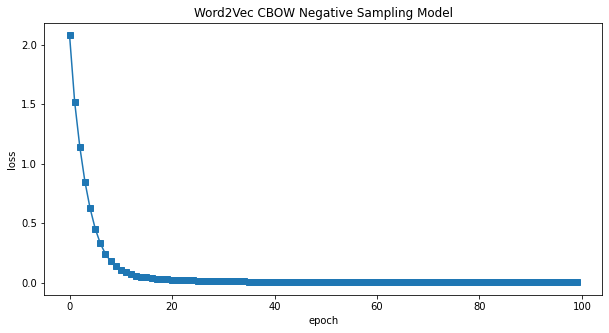

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(lst_loss, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec CBOW Model')
plt.show()

### 計算相似詞

In [13]:
def get_similarity(word, top_k, model, word2idx, idx2word):
    W = (model.in_embedding.weight.data + model.out_embedding.weight.data) / 2
    idx = word2idx.get(word, None)
    
    if not idx:
        # 當出現不在字典中的字詞時，顯示Out of vocabulary error
        raise ValueError("Out of vocabulary")
    else:
        x = W[idx]
        
        # 使用cosine相似計算字詞間的相似程度
        cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
        _, topk = torch.topk(cos, top_k+1)
        
        for i in topk[1:]:
            print(f"cosine sim={cos[int(i)]:.3f}: {idx2word[int(i)]}.")

In [19]:
get_similarity('love', 4, model, word2idx, idx2word)

cosine sim=0.347: sex.
cosine sim=0.303: happy.
cosine sim=0.276: over.
cosine sim=0.275: admirer.
